In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model,plot_prediction_examples
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from obspy.signal.trigger import recursive_sta_lta, trigger_onset
from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev, eval_task0_true_negative_rate
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [28]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)

dataset.filter(
    dataset["trace_chunk"].isin(["_aknoise", "_hwnoise", "_jpnoise"]), inplace=True
)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 7539/7539 [00:01<00:00, 6402.32it/s]


In [4]:
np.unique(dataset["trace_chunk"])

array(['_aknoise', '_hwnoise', '_jpnoise'], dtype=object)

In [5]:
len(dataset)

7539

In [17]:
# full test set
targets_path_my_noise = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/mynoise"
)
try:
    targets_path_my_noise.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_my_noise} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/mynoise exists


In [21]:
!ls /home/zhongyiyuan/volpick/model_training/Eval_targets

all  instance  instance_noise  lp_and_noise  mynoise  rg_and_noise  stead


In [18]:
replace_if_exist = False
generate_task0(
    dataset=dataset,
    output=targets_path_my_noise,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

/home/zhongyiyuan/volpick/model_training/Eval_targets/mynoise/task0.csv" has already existed. No task files will be generated.


# Load models

In [10]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

org_eqt = sbm.EQTransformer.from_pretrained("original")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_pn.cuda()
print(org_eqt.labels)
print(org_pn.labels)
print(org_eqt.norm)
print(org_pn.norm)
print(org_eqt.device)
print(org_pn.device)

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print(eqt_instance.labels)
print(pn_instance.labels)
print(eqt_instance.norm)
print(pn_instance.norm)
print(eqt_instance.device)
print(pn_instance.device)

eqt_stead = sbm.EQTransformer.from_pretrained("stead")
pn_stead = sbm.PhaseNet.from_pretrained("stead")
eqt_stead.cuda()
pn_stead.cuda()
print(eqt_stead.labels)
print(pn_stead.labels)
print(eqt_stead.norm)
print(pn_stead.norm)
print(eqt_stead.device)
print(pn_stead.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0
['Detection', 'P', 'S']
NPS
std
std
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [14]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "pretraining", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,pretraining,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,instance,0.13,0.050
1,EQTransformer_org,EQTransformer,original,0.01,0.001
2,EQTransformer_org_instance,EQTransformer,instance,0.04,0.040
3,PhaseNet_org,PhaseNet,original,0.28,0.170
4,PhaseNet_org_stead,PhaseNet,stead,0.01,0.040
5,EQTransformer_org_stead,EQTransformer,stead,0.02,0.010


In [15]:
p_thre_dict = {
    "vol_eqt": vol_eqt.default_args["P_threshold"],
    "vol_pn": vol_pn.default_args["P_threshold"],
    "org_eqt": 0.01,
    "org_pn": 0.28,
    "int_eqt": 0.04,
    "int_pn": 0.13,
    "std_eqt": 0.02,
    "std_pn": 0.01,
}
s_thre_dict = {
    "vol_eqt": vol_eqt.default_args["S_threshold"],
    "vol_pn": vol_pn.default_args["S_threshold"],
    "org_eqt": 0.001,
    "org_pn": 0.17,
    "int_eqt": 0.04,
    "int_pn": 0.05,
    "std_eqt": 0.01,
    "std_pn": 0.04,
}

In [31]:
p_thre_dict

{'vol_eqt': 0.22,
 'vol_pn': 0.39,
 'org_eqt': 0.01,
 'org_pn': 0.28,
 'int_eqt': 0.04,
 'int_pn': 0.13,
 'std_eqt': 0.02,
 'std_pn': 0.01}

In [32]:
s_thre_dict

{'vol_eqt': 0.22,
 'vol_pn': 0.34,
 'org_eqt': 0.001,
 'org_pn': 0.17,
 'int_eqt': 0.04,
 'int_pn': 0.05,
 'std_eqt': 0.01,
 'std_pn': 0.04}

In [16]:
model_dict = {
    "vol_eqt": vol_eqt,
    "vol_pn": vol_pn,
    "org_eqt": org_eqt,
    "org_pn": org_pn,
    "int_eqt": eqt_instance,
    "int_pn": pn_instance,
}
prob_thres_dict = {
    "vol_eqt": np.array([0.22]),
    "vol_pn": np.array([0.39, 0.34]),
    "org_eqt": np.array([0.001, 0.01]),
    "org_pn": np.array([0.28, 0.17]),
    "int_eqt": np.array([0.04]),
    "int_pn": np.array([0.13, 0.05]),
}

In [21]:
target_path_dataset_pairs = [
    (targets_path_my_noise, dataset),
]

target_i = targets_path_my_noise
model = vol_eqt

for model_name, model in model_dict.items():
    print(model_name)
    eval_task0_true_negative_rate(
        dev_test_set=dataset,
        model=model,
        exp_name=model_name,
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=prob_thres_dict[model_name],
        num_workers=32,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        sets=["test"],
        # sets=["test"],
        data_norm_type=model.norm,
    )

vol_eqt
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 357167.84it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.220


vol_pn
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 366072.65it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.390


Probability threshold: 0.340
org_eqt
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 365573.41it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
org_pn
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 358545.92it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.280


Probability threshold: 0.170
int_eqt
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 370759.40it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.040


int_pn
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 373928.85it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


In [27]:
len(dataset.dev())

3071

True
0.0159755479544401
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/e/version_0
vol_eqt2
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/vol_eqt2 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 2554/2554 [00:00<00:00, 349959.24it/s]

Number of examples in dev: 2554
0 earthquake traces
2554 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600


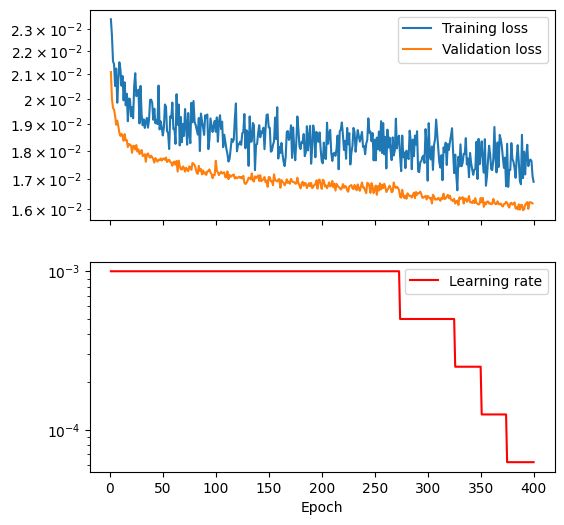

In [29]:
model_name = "vol_eqt2"
pl_model = load_best_model_from_base_dir(
    Path("/home/zhongyiyuan/volpick/model_training/weights_wholedataset/e")
)
model = pl_model.model
print(model_name)
eval_task0_true_negative_rate(
    dev_test_set=dataset,
    model=model,
    exp_name=model_name,
    targets_path=targets_path_my_noise,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity",
    # prob_thres=np.array([0.27,0.3,0.32]),
    # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
    prob_thres=np.array(
        [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    ),
    num_workers=32,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    sets=["dev"],
    # sets=["test"],
    data_norm_type=model.norm,
)

In [69]:
model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0"
)
stats_list = []
labels = {
    "org_eqt": "Original EQTransformer \cite{mousavi2020earthquake}",
    "int_eqt": "EQTransformer trained on INSTANCE \cite{munchmeyer2022picker}",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet \cite{zhu2019phasenet}",
    "int_pn": "PhaseNet trained on INSTANCE \cite{munchmeyer2022picker}",
    "vol_pn": "PhaseNet retrained in this study",
}
# for pred_dir in model_pred_save_path.iterdir():
for model_name in model_dict:
    pred_dir = model_pred_save_path / model_name
    if pred_dir.is_dir():
        df_true_negative_rate = pd.read_csv(pred_dir / "test_tnr.csv")
        p_tnr = df_true_negative_rate[
            np.isclose(df_true_negative_rate["prob_thre"], p_thre_dict[model_name])
        ]["p_true_negative_rate"].iloc[0]
        p_fpr = 1 - p_tnr
        s_tnr = df_true_negative_rate[
            np.isclose(df_true_negative_rate["prob_thre"], s_thre_dict[model_name])
        ]["s_true_negative_rate"].iloc[0]
        s_fpr = 1 - s_tnr
        stats_list.append(
            {
                "exp_name": model_name,
                "Model": labels[model_name],
                "True negative rate for p picking": p_tnr,
                "True negative rate for s picking": s_tnr,
                "False positive rate for p picking": p_fpr,
                "False positive rate for s picking": s_fpr,
            }
        )
#         print(pred_dir)
#         stats = opt_prob_metrics_dev(pred_dir)
#         stats_list.append(stats)
df_tnr_fpr = pd.DataFrame(stats_list)
# df.to_csv(model_pred_save_path / "optimal_threshold_dev.csv", index=False)
# df

In [70]:
df_tnr_fpr

,exp_name,Model,True negative rate for p picking,True negative rate for s picking,False positive rate for p picking,False positive rate for s picking
0,vol_eqt,EQTransformer retrained in this study,0.999198,0.996991,0.000802,0.003009
1,vol_pn,PhaseNet retrained in this study,0.998195,0.999398,0.001805,0.000602
2,org_eqt,Original EQTransformer \cite{mousavi2020earthq...,0.999599,0.991174,0.000401,0.008826
3,org_pn,Original PhaseNet \cite{zhu2019phasenet},0.998395,0.999799,0.001605,0.000201
4,int_eqt,EQTransformer trained on INSTANCE \cite{munchm...,0.996991,0.998997,0.003009,0.001003
5,int_pn,PhaseNet trained on INSTANCE \cite{munchmeyer2...,0.974925,0.879639,0.025075,0.120361


In [72]:
print(
    df_tnr_fpr[
        [
            "Model",
            "True negative rate for p picking",
            "True negative rate for s picking",
            "False positive rate for p picking",
            "False positive rate for s picking",
        ]
    ]
    .style.format(
        {
            "True negative rate for p picking": "{:.4f}",
            "False positive rate for p picking": "{:.4f}",
            "True negative rate for s picking": "{:.4f}",
            "False positive rate for s picking": "{:.4f}",
        },
        na_rep="None",
    )
    .hide(axis="index")
    .to_latex()
)

\begin{tabular}{lrrrr}
Model & True negative rate for p picking & True negative rate for s picking & False positive rate for p picking & False positive rate for s picking \\
EQTransformer retrained in this study & 0.9992 & 0.9970 & 0.0008 & 0.0030 \\
PhaseNet retrained in this study & 0.9982 & 0.9994 & 0.0018 & 0.0006 \\
Original EQTransformer \cite{mousavi2020earthquake} & 0.9996 & 0.9912 & 0.0004 & 0.0088 \\
Original PhaseNet \cite{zhu2019phasenet} & 0.9984 & 0.9998 & 0.0016 & 0.0002 \\
EQTransformer trained on INSTANCE \cite{munchmeyer2022picker} & 0.9970 & 0.9990 & 0.0030 & 0.0010 \\
PhaseNet trained on INSTANCE \cite{munchmeyer2022picker} & 0.9749 & 0.8796 & 0.0251 & 0.1204 \\
\end{tabular}



In [36]:
pred_dir.name

'int_eqt'

In [39]:
df_true_negative_rate[
    np.isclose(df_true_negative_rate["prob_thre"], s_thre_dict[model_name])
]

,prob_thre,p_TN,p_FP,p_true_negative_rate,s_TN,s_FP,s_true_negative_rate
1,0.05,4385,600,0.879639,4385,600,0.879639


# Models trained without noise examples

0.0164202954620122
/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/e_nonoise/version_0


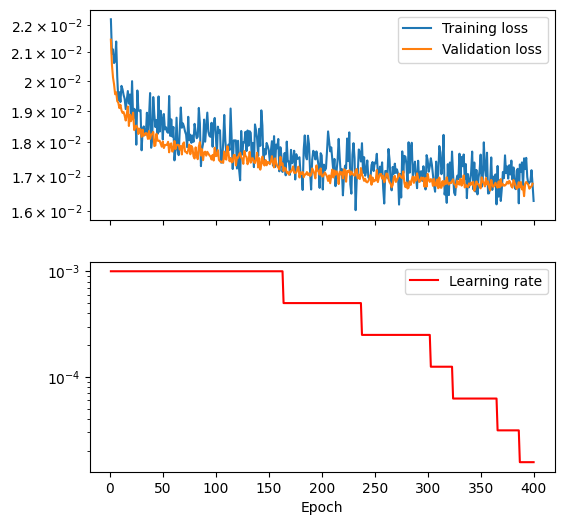

In [16]:
model_path = Path(
    "/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/e_nonoise"
)
eqt_nonoise = load_best_model_from_base_dir(model_path)

0.0461259819567203
/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/p_nonoise/version_0


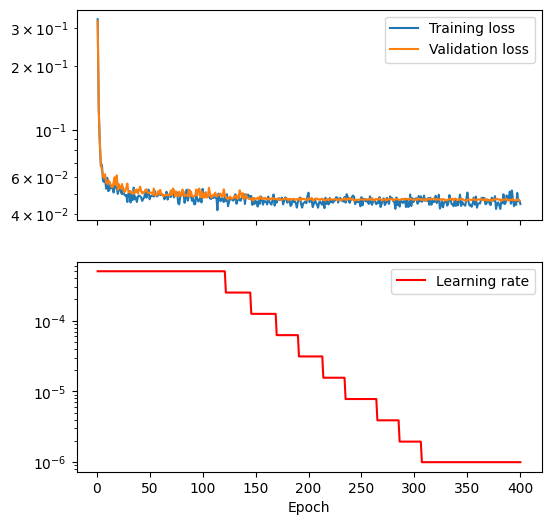

In [17]:
model_path = Path(
    "/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/p_nonoise"
)
pn_nonoise = load_best_model_from_base_dir(model_path)

0.0130411107093095
/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/instance_eqt_nonoise/version_0


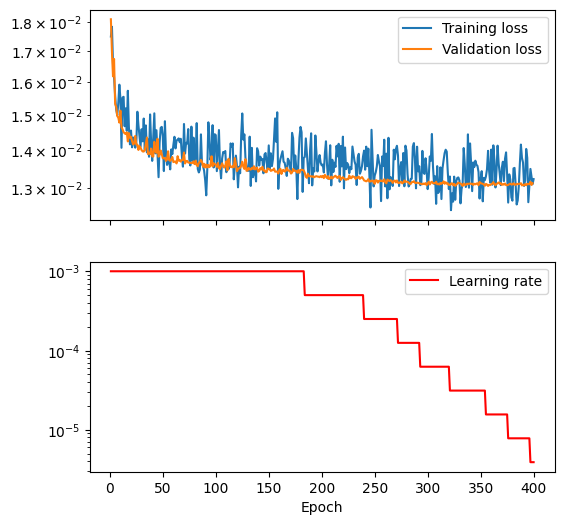

In [7]:
model_path = Path(
    "/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/instance_eqt_nonoise"
)
int_eqt_nonoise = load_best_model_from_base_dir(model_path)

0.0246657710522413
/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/instance_pn_nonoise/version_0


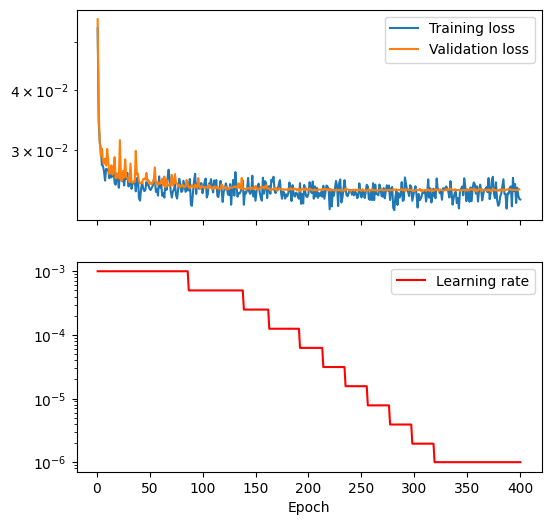

In [8]:
model_path = Path(
    "/home/zhongyiyuan/volpick/model_training/configs_nonoise/weights/instance_pn_nonoise"
)
int_pn_nonoise = load_best_model_from_base_dir(model_path)

In [9]:
# model_dict2 = {
#     "vol_eqt_nonoise": eqt_nonoise.model,
#     "vol_pn_nonoise": pn_nonoise.model,
# }
model_dict2 = {
    "int_eqt_nonoise": int_eqt_nonoise.model,
    "int_pn_nonoise": int_pn_nonoise.model,
}

In [10]:
int_eqt_nonoise.model.norm

'peak'

In [13]:
targets_path_my_noise

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets/mynoise')

In [11]:
for model_name, model in model_dict2.items():
    print(model_name)
    eval_task0_true_negative_rate(
        dev_test_set=dataset,
        model=model,
        exp_name=model_name,
        targets_path=targets_path_my_noise,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=np.array(
            [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
        ),
        num_workers=32,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        sets=["test"],
        # sets=["test"],
        data_norm_type=model.norm,
    )

int_eqt_nonoise
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/int_eqt_nonoise exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 321206.34it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
int_pn_nonoise
/home/zhongyiyuan/volpick/model_training/Noise_specificity/mynoise_pred/task0/int_pn_nonoise exists
Starting set: test


Preloading waveforms: 100%|██████████| 4985/4985 [00:00<00:00, 333459.94it/s]

Number of examples in test: 4985
0 earthquake traces
4985 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600


# For INSTANCE

In [2]:
data_instance_noise = sbd.InstanceNoise(
    sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="full"
)

In [3]:
len(data_instance_noise)

132288

In [3]:
data_instance_noise.filter(
    data_instance_noise["split"].isin(["dev", "test"]), inplace=True
)

In [4]:
len(data_instance_noise.test())

39752

In [5]:
data_instance_noise.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 53003/53003 [00:33<00:00, 1601.88it/s]


In [8]:
targets_path_instance_noise = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/instance_noise"
)
try:
    targets_path_instance_noise.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_instance_noise} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/instance_noise exists


In [13]:
replace_if_exist = False
generate_task0(
    dataset=data_instance_noise,
    output=targets_path_instance_noise,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=False,
    replace_if_exist=replace_if_exist,
)

  0%|          | 0/53003 [00:00<?, ?it/s]

100%|██████████| 53003/53003 [00:15<00:00, 3517.32it/s]


In [19]:
prob_thres_dict = {
    "vol_eqt": np.array([0.33, 0.46]),
    "vol_pn": np.array([0.41, 0.57]),
    "org_eqt": np.array([0.06, 0.22]),
    "org_pn": np.array([0.38, 0.45]),
    "int_eqt": np.array([0.22, 0.24]),
    "int_pn": np.array([0.29, 0.26]),
}
prob_thres_dict

{'vol_eqt': array([0.33, 0.46]),
 'vol_pn': array([0.41, 0.57]),
 'org_eqt': array([0.06, 0.22]),
 'org_pn': array([0.38, 0.45]),
 'int_eqt': array([0.22, 0.24]),
 'int_pn': array([0.29, 0.26])}

In [20]:
# target_path_dataset_pairs = [
#     (targets_path_my_noise, dataset),
# ]

# target_i = targets_path_my_noise
# model = vol_eqt

for model_name, model in model_dict.items():
    print(model_name)
    eval_task0_true_negative_rate(
        dev_test_set=data_instance_noise,
        model=model,
        exp_name=model_name,
        targets_path=targets_path_instance_noise,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=np.array(
            [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
        ),
        num_workers=32,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        sets=["test"],
        # sets=["test"],
        data_norm_type=model.norm,
    )

vol_eqt
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 352722.60it/s]


Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050
Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
vol_pn
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 361206.79it/s]


Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050
Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
org_eqt
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 364198.67it/s]

Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
org_pn
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 360724.63it/s]

Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
int_eqt
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 368692.52it/s]

Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
int_pn
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 360923.75it/s]

Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600


True
0.0159755479544401
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/e/version_0
vol_eqt2
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/vol_eqt2 exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 355450.70it/s]

Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600


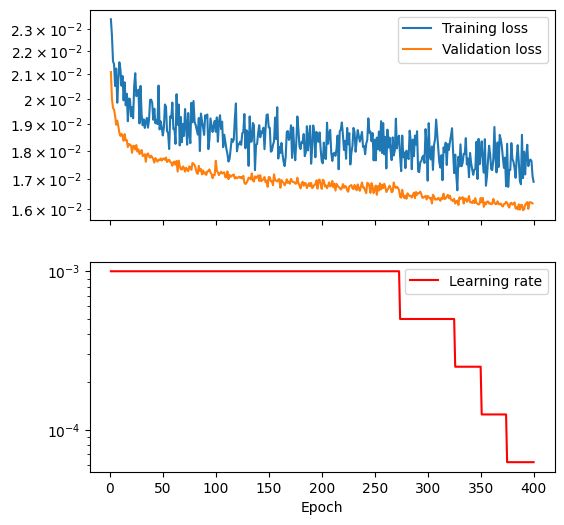

In [10]:
model_name = "vol_eqt2"
pl_model = load_best_model_from_base_dir(
    Path("/home/zhongyiyuan/volpick/model_training/weights_wholedataset/e")
)
model = pl_model.model
print(model_name)
eval_task0_true_negative_rate(
    dev_test_set=data_instance_noise,
    model=model,
    exp_name=model_name,
    targets_path=targets_path_instance_noise,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance",
    # prob_thres=np.array([0.27,0.3,0.32]),
    # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
    prob_thres=np.array(
        [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    ),
    num_workers=32,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    sets=["test"],
    # sets=["test"],
    data_norm_type=model.norm,
)

In [20]:
# target_path_dataset_pairs = [
#     (targets_path_my_noise, dataset),
# ]

# target_i = targets_path_my_noise
# model = vol_eqt

for model_name, model in model_dict2.items():
    print(model_name)
    eval_task0_true_negative_rate(
        dev_test_set=data_instance_noise,
        model=model,
        exp_name=model_name,
        targets_path=targets_path_instance_noise,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=np.array(
            [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
        ),
        num_workers=32,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        sets=["test"],
        # sets=["test"],
        data_norm_type=model.norm,
    )

int_eqt_nonoise
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/int_eqt_nonoise exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 352666.64it/s]


Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050
Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
int_pn_nonoise
/home/zhongyiyuan/volpick/model_training/Noise_specificity_instance/instance_noise_pred/task0/int_pn_nonoise exists
Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:00<00:00, 361106.66it/s]

Number of examples in test: 39752
0 earthquake traces
39752 noise traces
Probability threshold: 0.050


Probability threshold: 0.100
Probability threshold: 0.150
Probability threshold: 0.200
Probability threshold: 0.250
Probability threshold: 0.300
Probability threshold: 0.350
Probability threshold: 0.400
Probability threshold: 0.450
Probability threshold: 0.500
Probability threshold: 0.550
Probability threshold: 0.600
